In [1]:
import os

import imageio

import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.cm import jet

%matplotlib inline

from scipy.spatial.transform import Rotation
from scipy.stats import norm

from numpy import linalg as lin
import cv2 

from skimage import exposure, io
from skimage.exposure import match_histograms
import shutil

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.express as px
import plotly.graph_objects as go
init_notebook_mode(connected=True)

#path = "/home/sourabh/Documents/GIT/Python/Deep-NN/PoseTracking/minion"
path = "/home/sourabh/Documents/GIT/Python/Deep-NN/PoseTracking/Real/Buffalo/1000/captures_buffalo_1000_sift"
dataPath = "captures"

width, height = 640, 480

/opt/Conda/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning:

invalid value encountered in true_divide

/opt/Conda/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



AttributeError: 'NoneType' object has no attribute 'ravel'

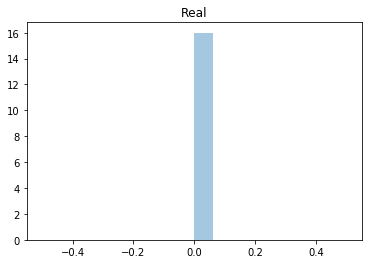

In [6]:
def visualizeData(images, title = " ", label=""):
    ax = sns.distplot(images, label='{}'.format(label), kde=True);
    ax.set_title(title)
    #plt.legend()
    #plt.show()

file = 'image_%05d_img'
n = 50

t = []
for i in range(n):
    
    f = file %i + '.png'
    
    image_folder = os.path.join(path, 'captures',  'R')
    img =  cv2.imread(os.path.join(image_folder, f), 0)
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    
    visualizeData(hist, title='Real', label=f)
    t.append(img.ravel())

plt.show()
plt.hist(t,256,[0,256]); plt.show()


t = []
for i in range(n):
    
    f = file %i + '.png'
    image_folder = os.path.join(path, 'captures',  'SynthTest')
    img =  cv2.imread(os.path.join(image_folder, f), 0)
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    visualizeData(hist,title='Synth', label=f)
    t.append(img.ravel())
    
plt.show()
plt.hist(t,256,[0,256]); plt.show()
plt.show()

In [9]:
file = 'image_%05d_img'
n= 100

image_folder = os.path.join(path, 'captures')

for i in range(n):
    
    f = file %i + '.png'
    
    sourceImagePath = os.path.join(image_folder,  'R')
    destImagePath = os.path.join(image_folder,  'SynthTest')
    
    sourceImage = os.path.join(sourceImagePath, f)
    destImage = os.path.join(destImagePath, f)
    
    matchedImage = match_histograms(cv2.imread(sourceImage), cv2.imread(destImage), multichannel=True)
    
    #.imshow(matchedImage)
    io.imsave(os.path.join(sourceImagePath, f), matchedImage)

In [46]:
def drawKeyPoints(dataSet, count,plot=True):
    
    # define the size of images
    fig = plt.figure(figsize=(20,10))

    plt.ion()
    # randomly select a sample
    sample = dataSet

    ax = plt.subplot(1, 2, 2)
    ax.set_title('Sample #{}'.format(count))

    # Using the same display function, defined earlier
    show_keypoints(sample['image'], sample['keypoints'], sample['bound'], ax, plot=plot)
        
def show_keypoints(image, key_pts, bound, ax, plot=True):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.gca().add_patch(patches.Rectangle((bound[0]),bound[1][0],bound[1][1],fill=False, linewidth=1,edgecolor='b')) 
    
    for i, k in enumerate(key_pts):
        plt.scatter(k[0], k[1], s=20, marker='+', c='m')
        #ax.annotate(i, xy=(k[0], k[1]), arrowprops=None)
        
    #plt.scatter(key_pts[:, 0], (key_pts[:, 1]), s=20, marker='+', c='m')
    
    if plot:
        plt.plot(key_pts[:, 0], key_pts[:, 1], c='m', label='Predicted')
    plt.axis('off')
    
def plot_mesh(faces, verts, img, R, t, cameraMatrix, filename = None):
    fig, ax = plt.subplots(1,1,figsize=(10,8))
    
    plt.imshow(img)
    verts_2d = np.matmul(cameraMatrix, np.matmul(R, verts.T) + t).T
    verts_2d = verts_2d[:,:2] / verts_2d[:,2, None]
    #verts_2d[:, 1] = 480 - verts_2d[:, 1]
    
    patches = []
    for face in faces:
        points = [verts_2d[i_vertex-1] for i_vertex in face]
        #print(points)
        poly = Polygon(points, True)
        patches.append(poly)
        
    p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.3)
    ax.add_collection(p)
    
    if filename is not None:
        plt.savefig("{}/{}_{}".format(image_folder, 'mesh' ,filename))
        
    plt.show()

In [47]:
class VisualizeData():
    
    def __init__(self, file="image_%05d_img", saveFig = False):
        self.saveFig = saveFig
        self.folderPath = os.path.join(path, dataPath)
        self.file = file
        
    def drawGroundTruth(self):
        self.drawData("GroundTruth/", "image_groundtruth_img", count=1, groundTruth=True, plot = True, saveFig=self.saveFig);
        
    def drawImages(self, real=False, num=5):
        for i in range(0, num):
            if not real:
                self.drawData("Train/", self.file %i, count = i, plot = True, saveFig=self.saveFig)
            else:
                self.drawData("RealTest/", self.file %i, count = i, real=True, plot = True, saveFig=self.saveFig)
                
    def drawMesh(self, real=False, num=5, PnP=False):
        if not real:
            print('Drawing Synthetic data')
            folder="Train/" 
        else:
            print('Drawing Real data')
            folder="RealTest/" 
        
        for i in range(0, num):
            self.verifySynthImages(folder = folder,file = self.file %i, real = real, PnP=PnP)
            
    def verifySynthImages(self, folder, file ,real=False, PnP = False):
        
        folderPath = os.path.join(self.folderPath, folder)
        
        point3D = pd.read_csv(os.path.join(self.folderPath, "GroundTruth/image_groundtruth_img-3DGT.txt"), header=None, sep=',').to_numpy().astype(float)
        vertices = pd.read_csv(os.path.join(self.folderPath, "GroundTruth/image_groundtruth_img-3DVertices.txt"), header=None, sep=',').to_numpy().astype(float) 
        faces = pd.read_csv(os.path.join(self.folderPath, "GroundTruth/image_groundtruth_img-3DFaces.txt"), header=None, sep=',').to_numpy().astype(int)
        
        img  = imageio.imread(os.path.join(folderPath, "{}.png".format(file)))
        
        if not real:
            cameraMatrix = pd.read_csv(os.path.join(self.folderPath, "GroundTruth/CameraMatrix.txt"), header=None, sep=',').to_numpy().astype(float)
            point2d = np.array(pd.read_csv(os.path.join(folderPath, "{}-GT.txt".format(file)), header=None))
        else:
            cameraMatrix = pd.read_csv(os.path.join(folderPath, "{}-Camera.txt".format(file)), header=None, sep=' ').to_numpy().astype(float)
            cameraMatrix = cameraMatrix.reshape((3, 3))
#             GTPointsInit = np.matmul(cameraMatrix, np.matmul(rot, np.squeeze(point3D).T) + trans).T
#             point2d1 = GTPointsInit[:,:2] / GTPointsInit[:,2, None]
            point2d = pd.read_csv(os.path.join(folderPath, "{}-GT.txt".format(file)), header=None, sep=' ').to_numpy().astype(float)
            
        if PnP:
            print('Performing PnP')
            ret, rvecs, tvecs = cv2.solvePnP(point3D,\
                                     point2d,\
                                     cameraMatrix,\
                                     np.zeros((1,5)), flags = 0)
    
            rot, part_jacob = cv2.Rodrigues(rvecs)
            trans = tvecs
        else:
            rot = np.array(pd.read_csv(os.path.join(folderPath, "{}-Rot.txt".format(file)), header=None, sep=' ')).reshape((3, 3))
            trans =  np.array(pd.read_csv(os.path.join(folderPath, "{}-Trans.txt".format(file)), header=None, sep=' ')).reshape((3,1))
            
        plot_mesh(faces, vertices, img, rot, trans, cameraMatrix)
        
    def drawData(self, folder, file, count, real = False, groundTruth=False, plot = False, saveFig=True):
        
        folderPath = os.path.join(self.folderPath, folder)
    
        img  = imageio.imread(os.path.join(folderPath, "{}.png".format(file)))

        sep = ':' if groundTruth else ','

        ## This gives Height and Width
        if not real:
            
            dataGT = pd.read_csv(os.path.join(folderPath, "{}-GT.txt".format(file)), header=None, sep=sep)
            dataBound = np.array(pd.read_csv(os.path.join(folderPath, "{}-BOUND.txt".format(file)), header=None))
            dataBound[1] = dataBound[1] - dataBound[0]
        else:
            dataGT = pd.read_csv(os.path.join(folderPath, "{}-GT.txt".format(file)), header=None, sep=' ')
            dataBound = np.array(pd.read_csv(os.path.join(folderPath, "{}-BOUND.txt".format(file)), header=None, sep=' ')).reshape((2, 2))
            #print(dataBound)
            #dataBound[1] = dataBound[1] + dataBound[0]
            
        if groundTruth:
            d = dataGT[0].str.strip(to_strip='( )')
            groundTruthKPs = np.array([i for i in d.str.split(',')], dtype=float);
            groundTruthKPs[:, 1] = height - groundTruthKPs[: , 1]

            dataSet = {'image' : img, 'keypoints' : groundTruthKPs, 'bound' : dataBound}
        else:
            dataGT = np.asarray(dataGT)
#             print(dataGT.shape)
            #dataGT[:, 1] = dataGT[: , 1] - 150
            dataSet = {'image' : img,'keypoints' : dataGT, 'bound' : dataBound }

        drawKeyPoints(dataSet, count = count, plot = plot)

        if saveFig:
            plt.savefig(os.path.join(folderPath, "{}-gt.png".format(file)))

In [48]:
path = "/home/sourabh/Documents/TU-Berlin/Thesis/Sytheticdata/ml-imagesynthesis/"
#path = "/home/sourabh/Documents/GIT/Python/Deep-NN/PoseTracking/Real/Buffalo/1000/captures_buffalo_1000_random"
vis = VisualizeData(saveFig = True)

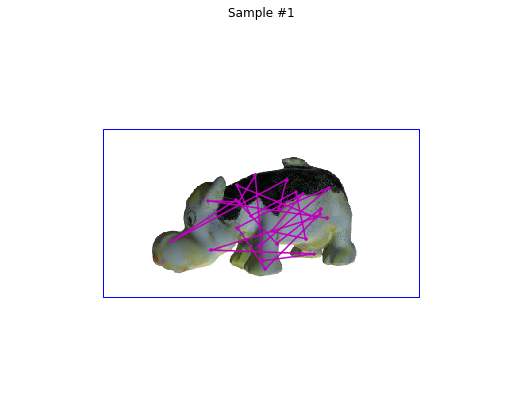

In [66]:
vis.drawGroundTruth()
#vis.drawImages(real=False, num=70)
#vis.drawMesh(real=True, num=5, PnP=False)

In [ ]:
#### Reprojected 3D points which are correctly ptojected and so th emesh is correct : START

#             predictedPoints = torch.cat((output_pts.type(torch.FloatTensor), torch.ones(GTPoints.shape[0],1, device=GTPoints.device)), dim=-1).t()
#             points3Dreprojected = np.matmul(gdRot.inverse().detach().cpu().numpy(), \
#                                    (np.matmul(cameraMatrix.inverse().detach().cpu().numpy(), predictedPoints.detach().cpu().numpy()) \
#                                     - gdTrans.detach().cpu().numpy())).T

#             rot1,dst = cv2.Rodrigues(gdRot.detach().cpu().numpy())
#             print('GT 2D points : ', cv2.projectPoints(point3D,rot1, gdTrans.detach().cpu().numpy(), cameraMatrix.detach().cpu().numpy(), 1.0))

#             point3D = points3Dreprojected
            #### Reprojected 3D points which are correctly ptojected and so th emesh is correct : END

In [32]:
def trajectory(path, directory = 'captures' ,folder="Train/", file="image_%05d%s" ,num=200):
    
    position = []
    translation = []
    
    for i in range(num):
        pos = pd.read_csv(os.path.join(path, directory, folder, file %(i, '_camera_pos.txt')), header=None, sep=",")
        pos[0] = pos[0].str.strip(to_strip='( )').astype(np.float)
        pos[2] = pos[2].str.strip(to_strip='( )').astype(np.float)

        position.append(np.array(pos))
                          
        trans = pd.read_csv(os.path.join(path, directory, folder, file %(i, '_img-Trans.txt')), header=None, sep=" ")
        translation.append(np.array(trans))
                          
    position = np.squeeze(np.asarray(position))
    translation = np.squeeze(np.array(translation))
    print(position.shape, translation.shape)
                          
    return position, translation

In [153]:
path = "/home/sourabh/Documents/TU-Berlin/Thesis/Sytheticdata/ml-imagesynthesis/"
from mpl_toolkits.mplot3d import Axes3D
pos, trans = trajectory(path)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(trans[:, 0], trans[:, 1], trans[:, 2], marker='o')
# plt.show()

data = []

data.append(go.Scatter3d(x=pos[:, 0], y=pos[:, 1], z=pos[:, 2], name='Camera trajectory', \
                         mode='markers', marker_color='gray', marker_size=2))

data.append(go.Scatter3d(x=trans[:, 0], y=trans[:, 1], z=trans[:, 2], name='Object position',\
                         mode='markers', marker_color='blue', marker_size=1.5))

fig = go.Figure(data=data)
#fig.update_traces(mode='markers', marker_line_width=5, marker_size=0.2)
fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    legend=dict(
        x=0.03,
        y=0.97,
        traceorder="normal"
        ),
    #margin=dict(r=10,t=20, b=10, l=10)
#     scene = dict(
#         xaxis = dict(nticks=4),
#          yaxis = dict(nticks=4),
#          zaxis = dict(nticks=4)),
    #width=1000,
    margin=dict(r=10, l=10, b=10, t=10)
    )

fig.write_image('trajectory_position_3D.webp')

#print(position)

(200, 3) (200, 3)


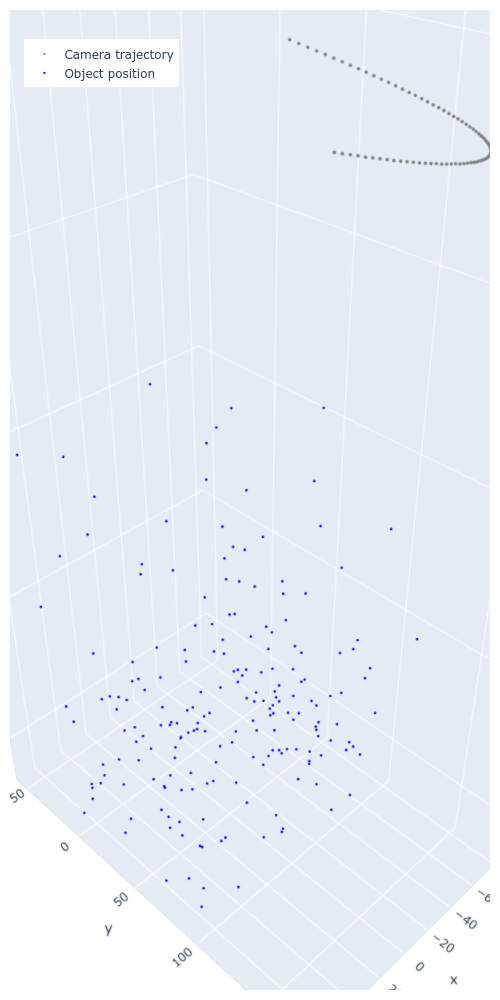

In [151]:
from IPython.display import Image

img_bytes = fig.to_image(format="png", width=500, height=1000, scale=1)
Image(img_bytes)